# KNN Regression (Revisi)

Implementasi KNN Regression untuk forecasting data time series NO2.

## 1. Import Library

Import library yang diperlukan untuk KNN Regression, termasuk pandas untuk manipulasi data, numpy untuk operasi numerik, matplotlib dan seaborn untuk visualisasi, serta scikit-learn untuk modeling dan evaluasi.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

## 2. Load Dataset Supervised

Load dataset supervised dengan lag 4 yang telah dipersiapkan sebelumnya. Dataset ini berisi nilai NO2 saat ini dan nilai-nilai lag (NO2 pada hari-hari sebelumnya).

In [26]:
df = pd.read_csv("dataset/supervised_data_lag_30.csv")
print("Shape dataset:", df.shape)
df.head()

Shape dataset: (6886, 41)


,t,NO2,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,...,t-30,year,month,day,dayofweek,dayofyear,month_sin,month_cos,day_sin,day_cos
0,2021-01-08,0.000032,0.000038,0.000045,0.000034,0.000034,0.000043,0.000051,0.000034,0.000034,...,0.000034,2021,1,8,4,8,0.5,0.866025,0.998717,-0.050649
1,2021-01-08,0.000026,0.000032,0.000038,0.000045,0.000034,0.000034,0.000043,0.000051,0.000034,...,0.000034,2021,1,8,4,8,0.5,0.866025,0.998717,-0.050649
2,2021-01-09,0.000020,0.000026,0.000032,0.000038,0.000045,0.000034,0.000034,0.000043,0.000051,...,0.000034,2021,1,9,5,9,0.5,0.866025,0.968077,-0.250653
3,2021-01-09,0.000013,0.000020,0.000026,0.000032,0.000038,0.000045,0.000034,0.000034,0.000043,...,0.000034,2021,1,9,5,9,0.5,0.866025,0.968077,-0.250653
4,2021-01-09,0.000013,0.000013,0.000020,0.000026,0.000032,0.000038,0.000045,0.000034,0.000034,...,0.000034,2021,1,9,5,9,0.5,0.866025,0.968077,-0.250653


## 3. Explorasi Data

Melihat informasi dataset meliputi tipe data, deskripsi statistik, dan pengecekan missing values untuk memastikan kualitas data sebelum modeling.

In [27]:
print("Info Dataset:")
print(df.info())
print("\nDeskripsi Statistik:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6886 entries, 0 to 6885
Data columns (total 41 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   t          6886 non-null   object 
 1   NO2        6886 non-null   float64
 2   t-1        6886 non-null   float64
 3   t-2        6886 non-null   float64
 4   t-3        6886 non-null   float64
 5   t-4        6886 non-null   float64
 6   t-5        6886 non-null   float64
 7   t-6        6886 non-null   float64
 8   t-7        6886 non-null   float64
 9   t-8        6886 non-null   float64
 10  t-9        6886 non-null   float64
 11  t-10       6886 non-null   float64
 12  t-11       6886 non-null   float64
 13  t-12       6886 non-null   float64
 14  t-13       6886 non-null   float64
 15  t-14       6886 non-null   float64
 16  t-15       6886 non-null   float64
 17  t-16       6886 non-null   float64
 18  t-17       6886 non-null   float64
 19  t-18       6886 non-null   float64

## 4. Analisis Autokorelasi
Menganalisis autokorelasi untuk memahami hubungan temporal dalam data time series NO2.

### 4.1. Autocorrelation Function (ACF) dan Partial Autocorrelation Function (PACF)

In [28]:
if "NO2" in df.columns:
    target_col = "NO2"
else:
    target_col = df.columns[-1]

target_data = df[target_col].dropna()

acf_values = acf(target_data, nlags=30, fft=False)
pacf_values = pacf(target_data, nlags=30, method="ywm")

print("Autocorrelation Function (ACF) Values:")
for lag in range(1, min(11, len(acf_values))):
    print(f"t-{lag:2d}: {acf_values[lag]:.4f}")

print("\n\nPartial Autocorrelation Function (PACF) Values:")
for lag in range(1, min(11, len(pacf_values))):
    print(f"t-{lag:2d}: {pacf_values[lag]:.4f}")

Autocorrelation Function (ACF) Values:
t- 1: 0.5990
t- 2: 0.5338
t- 3: 0.4471
t- 4: 0.3969
t- 5: 0.3589
t- 6: 0.3166
t- 7: 0.2581
t- 8: 0.2245
t- 9: 0.2092
t-10: 0.1758


Partial Autocorrelation Function (PACF) Values:
t- 1: 0.5990
t- 2: 0.2730
t- 3: 0.0861
t- 4: 0.0602
t- 5: 0.0507
t- 6: 0.0191
t- 7: -0.0293
t- 8: -0.0042
t- 9: 0.0279
t-10: -0.0082


### 4.2. Korelasi antara Target dan Lag Features

In [29]:
lag_cols = [col for col in df.columns if col.startswith("t-")]

correlations = {}
for lag_col in lag_cols:
    corr = df[[target_col, lag_col]].corr().iloc[0, 1]
    correlations[lag_col] = corr

sorted_correlations = sorted(
    correlations.items(), key=lambda x: abs(x[1]), reverse=True
)

high_corr_lags = [lag for lag, corr in correlations.items() if abs(corr) >= 0.5]
print(f"\n\nLag Features dengan korelasi > 0.5:")
for lag in high_corr_lags:
    print(f"{lag:10s}: {correlations[lag]:7.4f}")
print(f"\nTotal: {len(high_corr_lags)} fitur")



Lag Features dengan korelasi > 0.5:
t-1       :  0.5993
t-2       :  0.5343

Total: 2 fitur


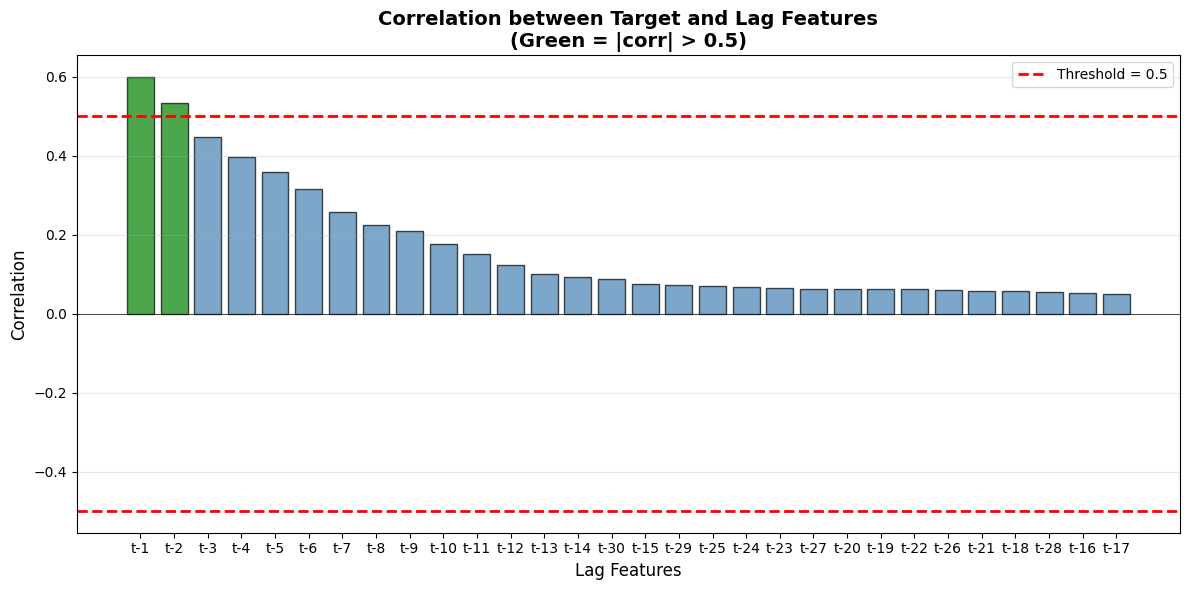

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))

lag_names = [lag for lag, _ in sorted_correlations]
corr_values = [corr for _, corr in sorted_correlations]

colors = ["green" if abs(c) > 0.5 else "steelblue" for c in corr_values]
bars = ax.bar(lag_names, corr_values, color=colors, alpha=0.7, edgecolor="black")

ax.axhline(y=0.5, color="red", linestyle="--", linewidth=2, label="Threshold = 0.5")
ax.axhline(y=-0.5, color="red", linestyle="--", linewidth=2)
ax.axhline(y=0, color="black", linestyle="-", linewidth=0.5)

ax.set_xlabel("Lag Features", fontsize=12)
ax.set_ylabel("Correlation", fontsize=12)
ax.set_title(
    "Correlation between Target and Lag Features\n(Green = |corr| > 0.5)",
    fontsize=14,
    fontweight="bold",
)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

## 5. Deteksi dan Penanganan Outlier

Mengidentifikasi dan menangani outlier menggunakan metode IQR (Interquartile Range) dan Z-Score.
### 5.1. Deteksi Outlier dengan IQR Method

In [31]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound


outliers_iqr, lower, upper = detect_outliers_iqr(df, target_col)

print("Deteksi Outlier dengan IQR Method:")
print(f"Q1 (25%): {df[target_col].quantile(0.25):.6f}")
print(f"Q3 (75%): {df[target_col].quantile(0.75):.6f}")
print(f"IQR: {df[target_col].quantile(0.75) - df[target_col].quantile(0.25):.6f}")
print(f"Lower Bound: {lower:.6f}")
print(f"Upper Bound: {upper:.6f}")
print(f"\nJumlah outlier: {len(outliers_iqr)} ({len(outliers_iqr)/len(df)*100:.2f}%)")
print(
    f"Jumlah data normal: {len(df) - len(outliers_iqr)} ({(len(df)-len(outliers_iqr))/len(df)*100:.2f}%)"
)

Deteksi Outlier dengan IQR Method:
Q1 (25%): 0.000010
Q3 (75%): 0.000022
IQR: 0.000012
Lower Bound: -0.000007
Upper Bound: 0.000040

Jumlah outlier: 153 (2.22%)
Jumlah data normal: 6733 (97.78%)


### 5.2. Deteksi Outlier dengan Z-Score Method

In [32]:
def detect_outliers_zscore(data, column, threshold=3):
    z_scores = np.abs(stats.zscore(data[column].dropna()))
    outliers = data[np.abs(stats.zscore(data[column].dropna())) > threshold]
    return outliers, z_scores


outliers_zscore, z_scores = detect_outliers_zscore(df, target_col, threshold=3)

print("Deteksi Outlier dengan Z-Score Method (threshold=3):")
print(f"Mean: {df[target_col].mean():.6f}")
print(f"Std: {df[target_col].std():.6f}")
print(
    f"\nJumlah outlier: {len(outliers_zscore)} ({len(outliers_zscore)/len(df)*100:.2f}%)"
)
print(
    f"Jumlah data normal: {len(df) - len(outliers_zscore)} ({(len(df)-len(outliers_zscore))/len(df)*100:.2f}%)"
)

Deteksi Outlier dengan Z-Score Method (threshold=3):
Mean: 0.000017
Std: 0.000010

Jumlah outlier: 57 (0.83%)
Jumlah data normal: 6829 (99.17%)


### 5.3. Visualisasi Outlier

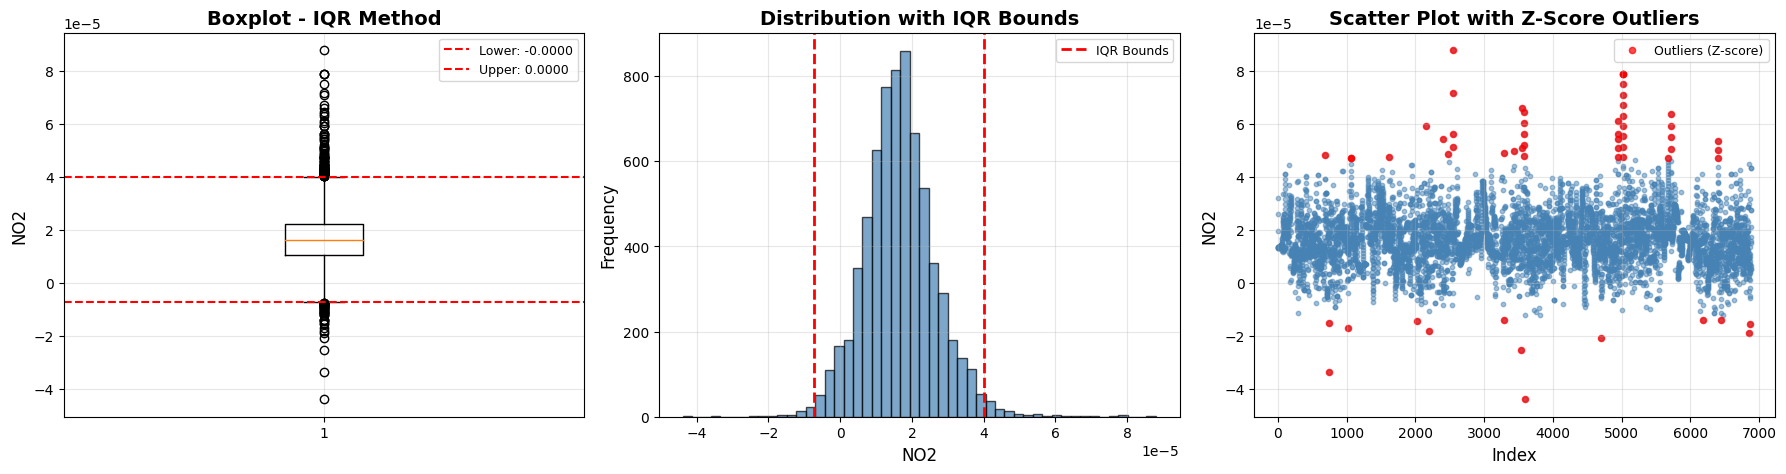

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].boxplot(df[target_col].dropna(), vert=True)
axes[0].set_ylabel(target_col, fontsize=12)
axes[0].set_title("Boxplot - IQR Method", fontsize=14, fontweight="bold")
axes[0].axhline(y=lower, color="r", linestyle="--", label=f"Lower: {lower:.4f}")
axes[0].axhline(y=upper, color="r", linestyle="--", label=f"Upper: {upper:.4f}")
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

axes[1].hist(
    df[target_col].dropna(), bins=50, alpha=0.7, color="steelblue", edgecolor="black"
)
axes[1].axvline(x=lower, color="r", linestyle="--", linewidth=2, label="IQR Bounds")
axes[1].axvline(x=upper, color="r", linestyle="--", linewidth=2)
axes[1].set_xlabel(target_col, fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[1].set_title("Distribution with IQR Bounds", fontsize=14, fontweight="bold")
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

axes[2].scatter(range(len(df)), df[target_col], alpha=0.5, s=10, c="steelblue")
axes[2].scatter(
    outliers_zscore.index,
    outliers_zscore[target_col],
    color="red",
    s=20,
    label="Outliers (Z-score)",
    alpha=0.7,
)
axes[2].set_xlabel("Index", fontsize=12)
axes[2].set_ylabel(target_col, fontsize=12)
axes[2].set_title("Scatter Plot with Z-Score Outliers", fontsize=14, fontweight="bold")
axes[2].legend(fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.4. Penanganan Outlier

Menghapus outlier yang terdeteksi menggunakan metode IQR untuk meningkatkan kualitas data.

In [34]:
df_clean = df[(df[target_col] >= lower) & (df[target_col] <= upper)].copy()

print("Penanganan Outlier:")
print(f"Jumlah data awal: {len(df)}")
print(f"Jumlah outlier dihapus: {len(df) - len(df_clean)}")
print(f"Jumlah data setelah cleaning: {len(df_clean)}")
print(f"Persentase data tersisa: {len(df_clean)/len(df)*100:.2f}%")

print(f"\n\nStatistik sebelum cleaning:")
print(df[target_col].describe())

print(f"\n\nStatistik setelah cleaning:")
print(df_clean[target_col].describe())

Penanganan Outlier:
Jumlah data awal: 6886
Jumlah outlier dihapus: 153
Jumlah data setelah cleaning: 6733
Persentase data tersisa: 97.78%


Statistik sebelum cleaning:
count    6886.000000
mean        0.000017
std         0.000010
min        -0.000044
25%         0.000010
50%         0.000016
75%         0.000022
max         0.000088
Name: NO2, dtype: float64


Statistik setelah cleaning:
count    6733.000000
mean        0.000016
std         0.000009
min        -0.000007
25%         0.000010
50%         0.000016
75%         0.000022
max         0.000040
Name: NO2, dtype: float64


## 6. Persiapan Data untuk Modeling

### Identifikasi Kolom Dataset

Langkah pertama adalah mengidentifikasi kolom-kolom yang ada dalam dataset untuk menentukan mana yang akan menjadi target (variabel yang akan diprediksi) dan mana yang akan menjadi fitur (variabel prediktor).

In [35]:
print("Kolom dalam dataset:")
print(df.columns.tolist())

if 'NO2' in df.columns:
    target_col = 'NO2'
else:
    target_col = df.columns[-1]

print(f"\nKolom target: {target_col}")

Kolom dalam dataset:
['t', 'NO2', 't-1', 't-2', 't-3', 't-4', 't-5', 't-6', 't-7', 't-8', 't-9', 't-10', 't-11', 't-12', 't-13', 't-14', 't-15', 't-16', 't-17', 't-18', 't-19', 't-20', 't-21', 't-22', 't-23', 't-24', 't-25', 't-26', 't-27', 't-28', 't-29', 't-30', 'year', 'month', 'day', 'dayofweek', 'dayofyear', 'month_sin', 'month_cos', 'day_sin', 'day_cos']

Kolom target: NO2


### Pemisahan Fitur dan Target

Pada tahap ini, kita memisahkan dataset menjadi:
- **Fitur (X)**: Variabel-variabel yang akan digunakan untuk prediksi (kolom lag)
- **Target (y)**: Variabel yang akan diprediksi (kolom NO2)

Beberapa kolom dihapus dari fitur karena:
- Kolom **'t'** (timestamp): Tidak dapat dinormalisasi dan tidak relevan untuk model
- Kolom **temporal** (day, dayofweek, year, month, dayofyear): Fitur waktu yang redundan
- Kolom **siklik** (month_sin, month_cos, day_sin, day_cos): Representasi siklik yang tidak diperlukan dalam konteks ini

In [36]:
X = df.drop(
    columns=[
        target_col,
        "t",
        "day",
        "dayofweek",
        "year",
        "month",
        "dayofyear",
        "month_sin",
        "month_cos",
        "day_sin",
        "day_cos",
    ]
)
y = df[target_col]

print(f"\nShape X: {X.shape}")
print(f"Shape y: {y.shape}")
print(f"\nKolom fitur yang digunakan:")
print(X.columns.tolist())


Shape X: (6886, 30)
Shape y: (6886,)

Kolom fitur yang digunakan:
['t-1', 't-2', 't-3', 't-4', 't-5', 't-6', 't-7', 't-8', 't-9', 't-10', 't-11', 't-12', 't-13', 't-14', 't-15', 't-16', 't-17', 't-18', 't-19', 't-20', 't-21', 't-22', 't-23', 't-24', 't-25', 't-26', 't-27', 't-28', 't-29', 't-30']


## 7. Split Data Train dan Test

Membagi data menjadi data training (80%) dan testing (20%). Gunakan `shuffle=False` untuk menjaga urutan waktu pada data time series.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

print("Shape data train:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print("\nShape data test:")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Shape data train:
X_train: (5508, 30), y_train: (5508,)

Shape data test:
X_test: (1378, 30), y_test: (1378,)


## 8. Normalisasi Data

Normalisasi data menggunakan MinMaxScaler agar semua fitur memiliki skala yang sama. KNN sangat sensitif terhadap skala data, sehingga normalisasi sangat penting.

In [38]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

normalized_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
normalized_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

normalized_train.to_csv('dataset/X_train_normalized.csv', index=False)
normalized_test.to_csv('dataset/X_test_normalized.csv', index=False)

print("Data hasil normalisasi telah disimpan:")
print(f"- X_train_normalized.csv: {normalized_train.shape}")
print(f"- X_test_normalized.csv: {normalized_test.shape}")
print()
print("Data berhasil dinormalisasi")
print(f"Mean X_train_scaled: {X_train_scaled.mean():.6f}")
print(f"Std X_train_scaled: {X_train_scaled.std():.6f}")

Data hasil normalisasi telah disimpan:
- X_train_normalized.csv: (5508, 30)
- X_test_normalized.csv: (1378, 30)

Data berhasil dinormalisasi
Mean X_train_scaled: 0.460221
Std X_train_scaled: 0.076793


## 9. Training Model KNN Regression

Membuat model KNN Regression dengan parameter awal: k=3 neighbors, uniform weights, dan euclidean distance sebagai metric.

In [39]:
knn_model = KNeighborsRegressor(n_neighbors=5, weights='uniform', metric='euclidean')

knn_model.fit(X_train_scaled, y_train)

print("Model KNN Regression berhasil ditraining")
print(f"Jumlah neighbors (k): {knn_model.n_neighbors}")
print(f"Weights: {knn_model.weights}")
print(f"Metric: {knn_model.metric}")

Model KNN Regression berhasil ditraining
Jumlah neighbors (k): 5
Weights: uniform
Metric: euclidean


## 10. Prediksi pada Data Test

Melakukan prediksi pada data test dan data train menggunakan model yang telah ditraining.

In [40]:
y_pred = knn_model.predict(X_test_scaled)
y_train_pred = knn_model.predict(X_train_scaled)

print("Prediksi berhasil dilakukan")
print(f"Shape y_train_pred: {y_train_pred.shape}, Shape y_pred: {y_pred.shape}")

Prediksi berhasil dilakukan
Shape y_train_pred: (5508,), Shape y_pred: (1378,)


## 11. Evaluasi Model dengan MAPE
Menghitung metrik evaluasi model meliputi MSE, RMSE, MAE, MAPE, dan R² Score untuk data training dan testing.

In [41]:
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred)
mape_test = mean_absolute_percentage_error(y_test, y_pred) * 100
r2_test = r2_score(y_test, y_pred)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred) * 100
r2_train = r2_score(y_train, y_train_pred)

print("EVALUASI MODEL KNN REGRESSION")
print("\nMetrik pada Data Training:")
print(f"MSE  : {mse_train:.6f}")
print(f"RMSE : {rmse_train:.6f}")
print(f"MAE  : {mae_train:.6f}")
print(f"MAPE : {mape_train:.2f}%")
print(f"R²   : {r2_train:.6f}")
print("\nMetrik pada Data Testing:")
print(f"MSE  : {mse_test:.6f}")
print(f"RMSE : {rmse_test:.6f}")
print(f"MAE  : {mae_test:.6f}")
print(f"MAPE : {mape_test:.2f}%")
print(f"R²   : {r2_test:.6f}")

EVALUASI MODEL KNN REGRESSION

Metrik pada Data Training:
MSE  : 0.000000
RMSE : 0.000007
MAE  : 0.000005
MAPE : 204.62%
R²   : 0.537615

Metrik pada Data Testing:
MSE  : 0.000000
RMSE : 0.000008
MAE  : 0.000006
MAPE : 150.14%
R²   : 0.298930


## 12. Visualisasi Hasil Prediksi

Visualisasi hasil prediksi dengan dua plot: perbandingan time series antara nilai aktual dan prediksi, serta scatter plot untuk melihat seberapa dekat prediksi dengan nilai aktual.

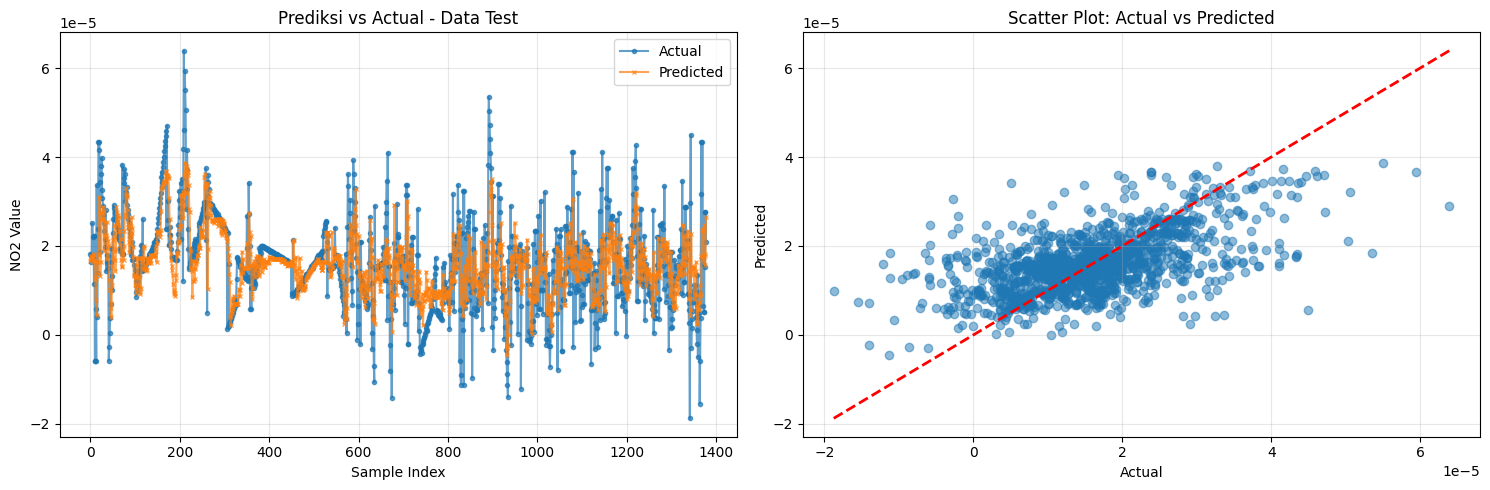

In [42]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(y_test.values, label='Actual', marker='o', markersize=3, alpha=0.7)
plt.plot(y_pred, label='Predicted', marker='x', markersize=3, alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('NO2 Value')
plt.title('Prediksi vs Actual - Data Test')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter Plot: Actual vs Predicted')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 12.1. Analisis Error dan MAPE Distribution

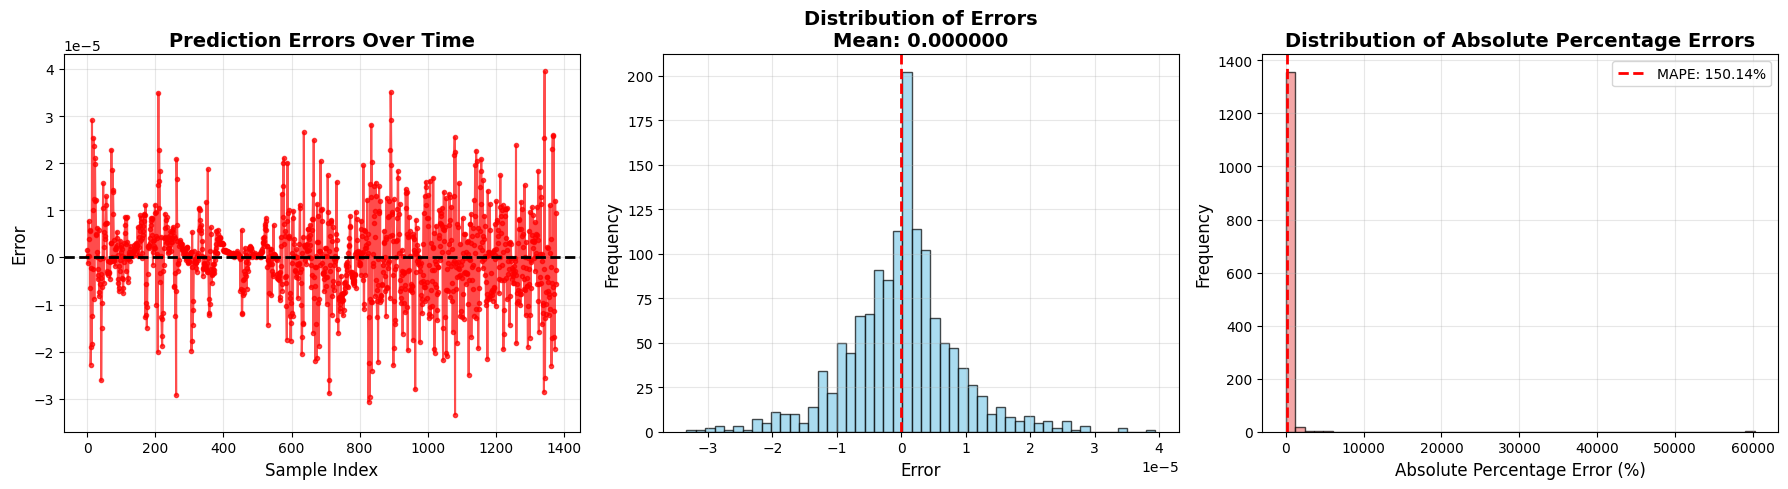

Statistik Error:
Mean Error: 0.000000
Std Error: 0.000008
Min Error: -0.000033
Max Error: 0.000039

Mean Absolute Percentage Error (MAPE): 150.14%
Median Absolute Percentage Error: 26.60%


In [43]:
errors = y_test.values - y_pred
percentage_errors = np.abs(errors / y_test.values) * 100

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(errors, marker="o", markersize=3, alpha=0.7, color="red")
axes[0].axhline(y=0, color="black", linestyle="--", linewidth=2)
axes[0].set_xlabel("Sample Index", fontsize=12)
axes[0].set_ylabel("Error", fontsize=12)
axes[0].set_title("Prediction Errors Over Time", fontsize=14, fontweight="bold")
axes[0].grid(True, alpha=0.3)

axes[1].hist(errors, bins=50, color="skyblue", edgecolor="black", alpha=0.7)
axes[1].axvline(x=0, color="red", linestyle="--", linewidth=2)
axes[1].set_xlabel("Error", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[1].set_title(
    f"Distribution of Errors\nMean: {errors.mean():.6f}", fontsize=14, fontweight="bold"
)
axes[1].grid(True, alpha=0.3)

axes[2].hist(
    percentage_errors, bins=50, color="lightcoral", edgecolor="black", alpha=0.7
)
axes[2].axvline(
    x=mape_test,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"MAPE: {mape_test:.2f}%",
)
axes[2].set_xlabel("Absolute Percentage Error (%)", fontsize=12)
axes[2].set_ylabel("Frequency", fontsize=12)
axes[2].set_title(
    "Distribution of Absolute Percentage Errors", fontsize=14, fontweight="bold"
)
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Statistik Error:")
print(f"Mean Error: {errors.mean():.6f}")
print(f"Std Error: {errors.std():.6f}")
print(f"Min Error: {errors.min():.6f}")
print(f"Max Error: {errors.max():.6f}")
print(f"\nMean Absolute Percentage Error (MAPE): {mape_test:.2f}%")
print(f"Median Absolute Percentage Error: {np.median(percentage_errors):.2f}%")

## 13. Residual Analysis

Analisis residual (selisih antara nilai aktual dan prediksi) untuk mengevaluasi kualitas model melalui residual plot, histogram distribusi residual, dan Q-Q plot untuk cek normalitas.

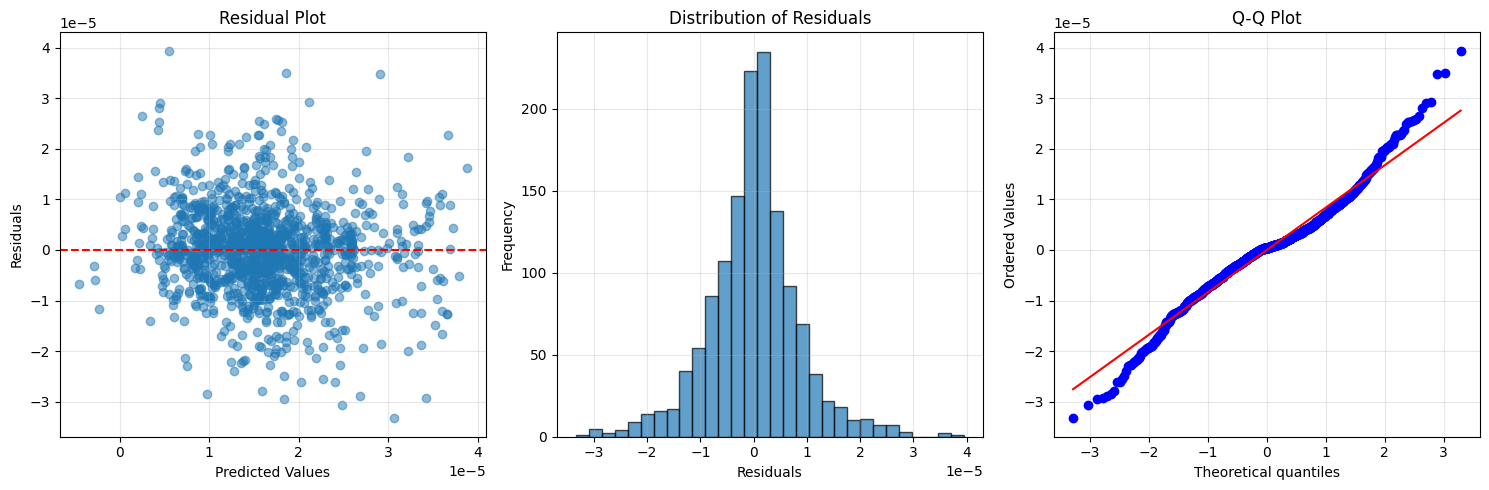

Mean Residual: 0.000000
Std Residual: 0.000008


In [44]:
residuals = y_test.values - y_pred

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)

from scipy import stats
plt.subplot(1, 3, 3)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean Residual: {residuals.mean():.6f}")
print(f"Std Residual: {residuals.std():.6f}")

## 14. Hyperparameter Tuning - Mencari K Optimal

Mencari nilai k (jumlah neighbors) optimal dengan mencoba berbagai nilai k dari 1 hingga 20, kemudian membandingkan R² Score pada data training dan testing untuk setiap nilai k.

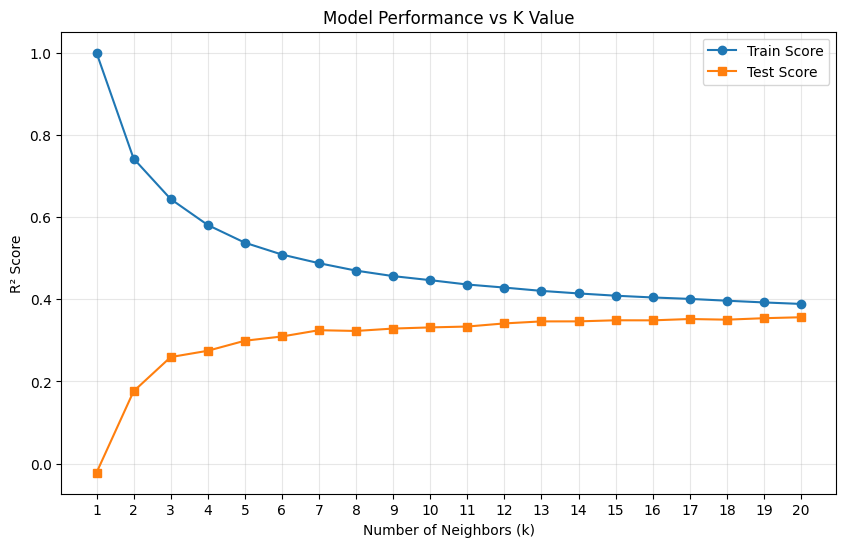


Optimal K: 20
Best Test Score (R²): 0.356111


In [45]:
k_range = range(1, 21)
train_scores = []
test_scores = []

for k in k_range:
    knn_temp = KNeighborsRegressor(n_neighbors=k, weights='uniform')
    knn_temp.fit(X_train_scaled, y_train)
    
    train_scores.append(knn_temp.score(X_train_scaled, y_train))
    
    test_scores.append(knn_temp.score(X_test_scaled, y_test))

plt.figure(figsize=(10, 6))
plt.plot(k_range, train_scores, label='Train Score', marker='o')
plt.plot(k_range, test_scores, label='Test Score', marker='s')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('R² Score')
plt.title('Model Performance vs K Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.show()

optimal_k = k_range[np.argmax(test_scores)]
print(f"\nOptimal K: {optimal_k}")
print(f"Best Test Score (R²): {max(test_scores):.6f}")

## 15. Training Model dengan K Optimal

Melatih ulang model KNN menggunakan nilai k optimal yang telah ditemukan, kemudian mengevaluasi performanya.

In [46]:
knn_optimal = KNeighborsRegressor(n_neighbors=optimal_k, weights='uniform')
knn_optimal.fit(X_train_scaled, y_train)

y_pred_optimal = knn_optimal.predict(X_test_scaled)
y_train_pred_optimal = knn_optimal.predict(X_train_scaled)

mse_test_opt = mean_squared_error(y_test, y_pred_optimal)
rmse_test_opt = np.sqrt(mse_test_opt)
mae_test_opt = mean_absolute_error(y_test, y_pred_optimal)
r2_test_opt = r2_score(y_test, y_pred_optimal)

mse_train_opt = mean_squared_error(y_train, y_train_pred_optimal)
rmse_train_opt = np.sqrt(mse_train_opt)
mae_train_opt = mean_absolute_error(y_train, y_train_pred_optimal)
r2_train_opt = r2_score(y_train, y_train_pred_optimal)

print(f"MODEL KNN REGRESSION DENGAN K OPTIMAL = {optimal_k}")
print("\nMetrik pada Data Training:")
print(f"MSE  : {mse_train_opt:.6f}")
print(f"RMSE : {rmse_train_opt:.6f}")
print(f"MAE  : {mae_train_opt:.6f}")
print(f"R²   : {r2_train_opt:.6f}")
print("\nMetrik pada Data Testing:")
print(f"MSE  : {mse_test_opt:.6f}")
print(f"RMSE : {rmse_test_opt:.6f}")
print(f"MAE  : {mae_test_opt:.6f}")
print(f"R²   : {r2_test_opt:.6f}")

MODEL KNN REGRESSION DENGAN K OPTIMAL = 20

Metrik pada Data Training:
MSE  : 0.000000
RMSE : 0.000008
MAE  : 0.000006
R²   : 0.388540

Metrik pada Data Testing:
MSE  : 0.000000
RMSE : 0.000008
MAE  : 0.000006
R²   : 0.356111


## 16. Perbandingan Model Default vs Optimal

Membandingkan performa model default (k=5) dengan model optimal untuk melihat peningkatan performa setelah hyperparameter tuning.

In [47]:
comparison = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²'],
    'Default (k=5) - Train': [mse_train, rmse_train, mae_train, r2_train],
    'Default (k=5) - Test': [mse_test, rmse_test, mae_test, r2_test],
    f'Optimal (k={optimal_k}) - Train': [mse_train_opt, rmse_train_opt, mae_train_opt, r2_train_opt],
    f'Optimal (k={optimal_k}) - Test': [mse_test_opt, rmse_test_opt, mae_test_opt, r2_test_opt]
})

print("\nPerbandingan Model:")
print(comparison.to_string(index=False))


Perbandingan Model:
Metric  Default (k=5) - Train  Default (k=5) - Test  Optimal (k=20) - Train  Optimal (k=20) - Test
   MSE           4.690138e-11          7.216778e-11            6.202263e-11           6.628154e-11
  RMSE           6.848458e-06          8.495162e-06            7.875445e-06           8.141348e-06
   MAE           4.773299e-06          6.080259e-06            5.515798e-06           5.728868e-06
    R²           5.376151e-01          2.989298e-01            3.885398e-01           3.561114e-01


## 17. Visualisasi Hasil Model Optimal

Visualisasi hasil prediksi model optimal dengan time series plot dan scatter plot untuk mengevaluasi kualitas prediksi secara visual.

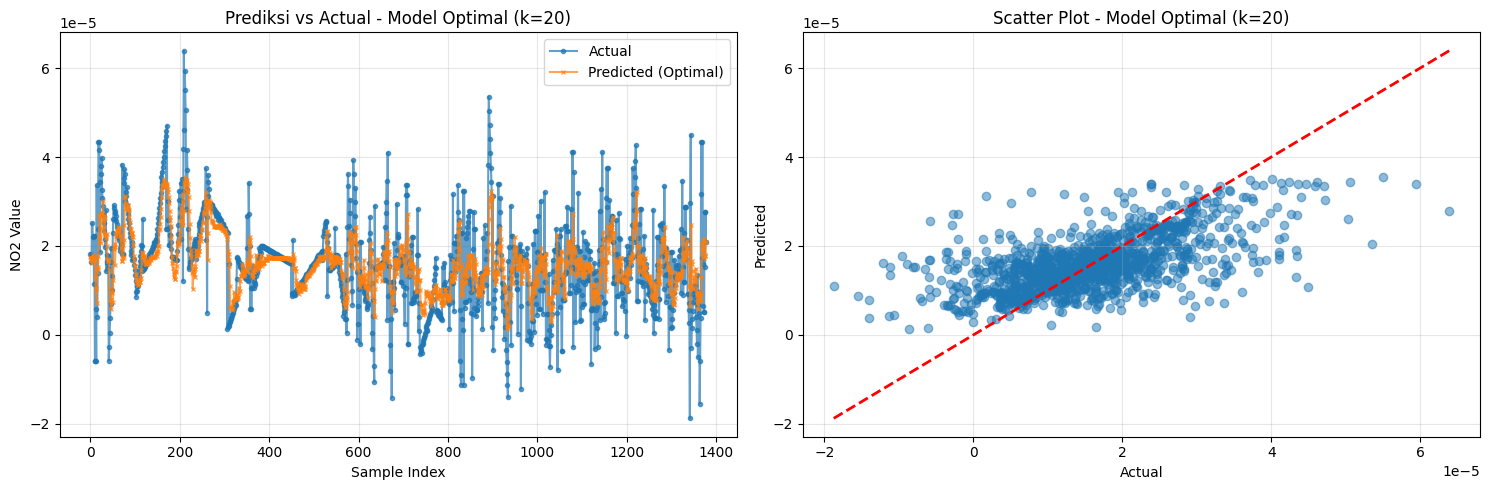

In [48]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(y_test.values, label='Actual', marker='o', markersize=3, alpha=0.7)
plt.plot(y_pred_optimal, label='Predicted (Optimal)', marker='x', markersize=3, alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('NO2 Value')
plt.title(f'Prediksi vs Actual - Model Optimal (k={optimal_k})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_optimal, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Scatter Plot - Model Optimal (k={optimal_k})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()